In [4]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../funcs')
from spectral1d import QuantumReflection

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev

In [5]:
def forcing(x,l):
    """Forcing function"""
    forcing_function = 100. * np.cos(2*x*np.pi/l) * np.cos(5.*x*np.pi/l)
    return forcing_function

def solutionAnalytic(x, l):
    """Analytic solution"""
    solution = (100.*(-58+116*x + 49*np.cos(3*np.pi*x) + 9*np.cos(7*np.pi*x))/(882 * np.pi**2)) + 0.5*(1 + x)
    return solution

# boundary-verifying function and its second derivative
def g(x,l):
    return x**3 - 0.5*((x-1)**3)

def d2g(x,l):
    return 3*x + 3

@np.vectorize
def freqs_inv(k):
    """solution operator in frequency domain"""
    return 1/(np.pi**2*k**2)

def break_points_pwc(n_pts, eps=1e-6): 
    """Break points for piecewise Chebychev interpolation"""
    pt = n_pts // 2
    break_pts_1 = []

    # break points for the first half of the spectrum
    while pt > 1:
        pt = pt // 2
        break_pts_1.append(pt-eps)

    # break points for the second half of the spectrum
    break_pts_1 = break_pts_1[::-1]
    break_pts_1.append((n_pts/2)-eps)
    break_pts_1.append(n_pts-eps)

    # combine the two lists and return
    return (break_pts_1)


/var/folders/tn/bpv7203512s5w_qmpd5848z80000gn/T/ipykernel_11191/2450509648.py:37: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(num_qubits=n_state_qubits_ext,inverse=False).to_gate()


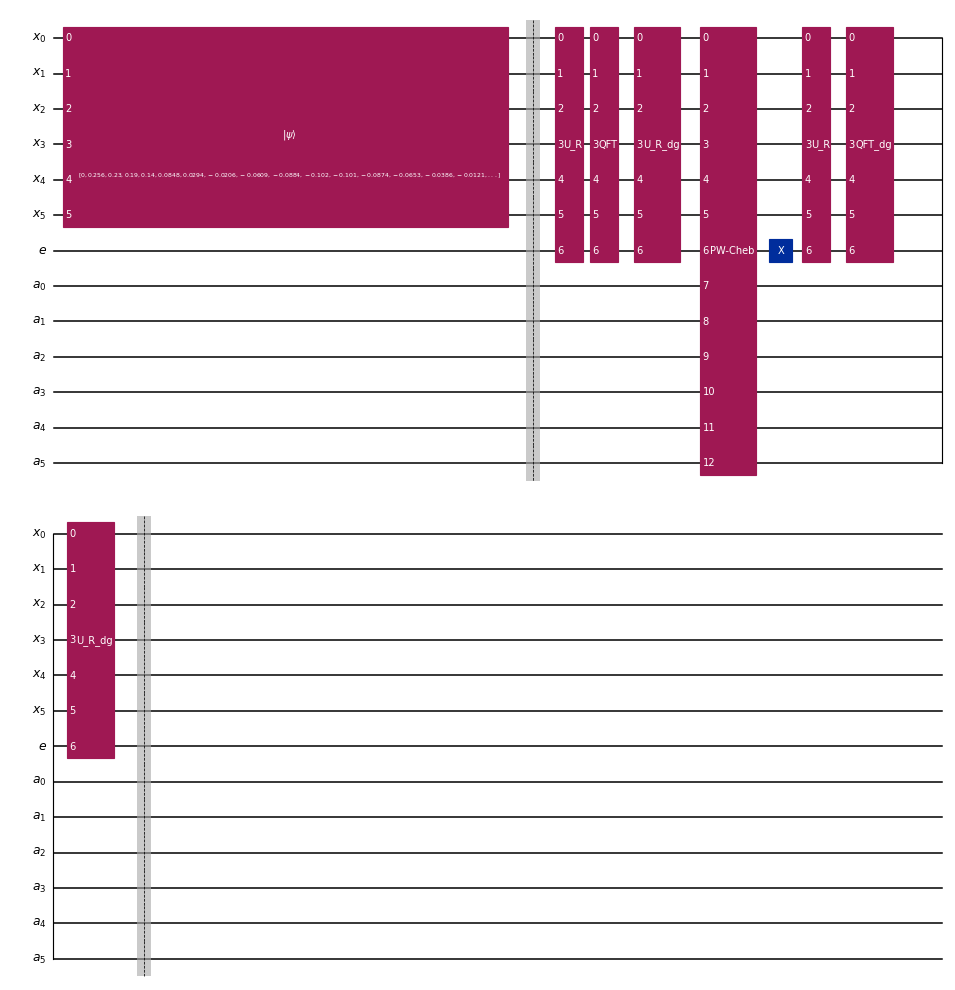

In [ ]:
# number of qubits for discretisation
n_state_qubits = 6                          # excluding the extended domain
n_state_qubits_ext = n_state_qubits + 1     # including the extended domain

n_pts = 2**n_state_qubits
n_pts_ext = 2**n_state_qubits_ext

# discretize the domain interval [0,1]
l     = 1.          # domain
l_ext = 2*l         # extended domain
h     = l/n_pts 
x     = np.linspace(0, l-h, n_pts)

# forcing vector
f_i    = forcing(x, 1)
f_i   += d2g(x, 1)
f_i[0] = 0.   # make sure zero at the first element
norm_f = np.linalg.norm(f_i)
f      = f_i/norm_f

# initialise quantum circuit with n_state_qubits and n_state_qubits+1 ancillas
qcs = QuantumRegister(n_state_qubits, 'x')  # spatial discretisation qubits
qce = QuantumRegister(1, 'e')               # extension qubit
qca = QuantumRegister(n_state_qubits, 'a')  # ancillary qubits
qc  = QuantumCircuit(qcs, qce, qca)

# initialise state using in-built Qiskit state prep function
qc.initialize(f, list(range(n_state_qubits)))
qc.barrier()

# add reflection U_R to the circuit
qr = QuantumReflection(n_state_qubits, 1)   # using default shift method "mcx"
qr_gate = qr.build()
qc.append(qr_gate, list(range(qr.n_dst)))

# apply QFT
qft = QFT(num_qubits=n_state_qubits_ext,inverse=False).to_gate()
qc.append(qft, list(range(n_state_qubits_ext)))

# add inverse of U_R to the circuit
qref_inv = qr.inverse()
qr_inv_gate = qref_inv.to_gate(label="U_R_dg")
qc.append(qr_inv_gate, list(range(qr.n_dst)))  

# piecewise Chebyshev approximation
eps    = 1.e-6
degree = 4      # degree of the Chebyshev approximation

# manually set breakpoints
if n_pts <= 32:
    breakpoints = break_points_pwc(n_pts, eps)
else:
    breakpoints = [1-eps, 2-eps, 3-eps, 4-eps, 8-eps, 16-eps, 32-eps, n_pts]  

# build piecewise Chebyshev approximation 
pw_approximation = PiecewiseChebyshev(freqs_inv, degree, breakpoints, n_state_qubits)
pw_approximation._build()

# append the piecewise Chebyshev approximation to the circuit
pw_gate       = pw_approximation.to_instruction() 
qlist         = list(range(2*n_state_qubits+1))
pw_gate.label = 'PW-Cheb'
qc.append(pw_gate, qlist)

# swap the polynomial coefficients to the first half of the extended vector
qc.x(n_state_qubits)

# apply inverse spectral transformation
qc.append(qr_gate, list(range(qr.n_dst)))
qc.append(qft.inverse(), list(range(n_state_qubits_ext))) 
qc.append(qr_inv_gate, list(range(qr.n_dst)))  

qc.barrier()

# visualize circuit
qc.draw("mpl", scale=0.55)

In [7]:
state = Statevector.from_label('0' * qc.num_qubits)
state = state.evolve(qc)

# extract the result from the state 
out = np.array(state.data[0:n_pts_ext])
result = np.real(norm_f*out)

# L2 norm of the error
error = np.linalg.norm((result[0:n_pts] + g(x[0:n_pts],l)) - solutionAnalytic(x[0:n_pts], l))
print('L2 norm of the error: ', error / n_pts)

L2 norm of the error:  0.0002205973062277065


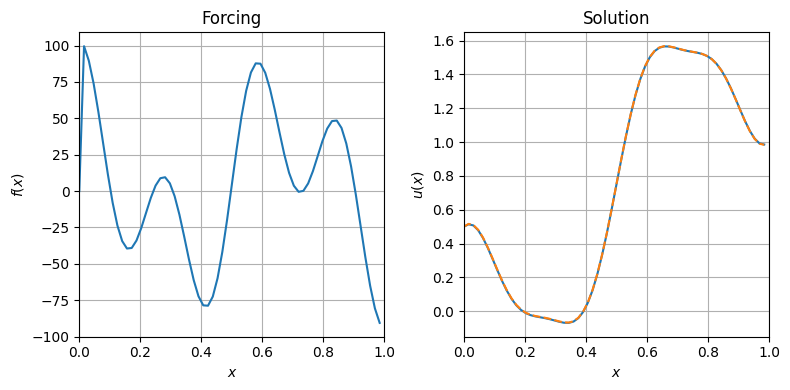

In [8]:
# plot the forcing and solution
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1) 
plt.title('Forcing') 
plt.plot(x, f_i)
plt.xlim(0, l)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid()

plt.subplot(1, 2, 2)  
plt.title('Solution')
plt.plot(x, result[0:n_pts]+g(x,l))
plt.plot(x, solutionAnalytic(x,l), '--')
plt.xlim(0, l)
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.grid()

plt.tight_layout()
plt.show()

In [9]:
from qiskit.compiler import transpile
transp = transpile(qc, basis_gates=['u3','cx'])
transp.count_ops()

OrderedDict([('u3', 75668), ('cx', 56869), ('reset', 6), ('barrier', 2)])